# Capstone Project


## Toronto neighborhoods: Where to live


## Table of Contents


1. Introduction

2. Data

3. Methodology

4. Results

5. Discussion    

6. Conclusion 

## 1. Introduction
This notebook targets to describe different neighborhoods in Toronto to help people make choices of which places fit their interests. This project results can help people identify where is quiet, where is more crowded with lots of shopping centers, etc. From that, they can decide which places fits their lifestyle. Our audience is people who is planning to move to Toronto.

## 2. Data

**Data Source**
1. a list of neighborhoods in Toronto is scraped from Wkipedia https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
2. a link to a csv file that has the geographical coordinates of each postal code http://cocl.us/Geospatial_data
3. a list of venue categories is requested from Foursquare API https://developer.foursquare.com/docs/build-with-foursquare/categories/.

**Data preparation**


To describe the different between Toronto neighborhoods, the feature of neighborhood (from Toronto neighborhood data) and feature of Venues and Main venues category (from Foursquare dataset) will be extracted.


For the Toronto neighborhood data, after scraping from Wikipedia, the list is transformed into a pandas dataframe and merged with the geographical coordinates file. This data contains 10 boroughs and 103 neighborhoods.


Using Foursquare API to explore the neighborhood and then segment them to get the data contains the name of venues, category, and corresponding latitude and longitude.
I also request from Foursquare API a list of venues and main venue category and then merge with Toronto data to get the final dataset.

## 3. Methodology

**Import Library**

In [1]:
!pip install beautifulsoup4
!pip install lxml
!pip install requests
from bs4 import BeautifulSoup
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

# convert an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict

# map rendering library
!pip install folium
import folium

# library to handle JSON files
import json

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
import xml.etree.ElementTree as et 

print("Done!")

     |████████████████████████████████| 102kB 10.0MB/s ta 0:00:01
Done!


**Build dataframe of Toronto**

In [2]:
# scrape the wikipedia page to obtain the data in the table of postal codes
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

source=requests.get(url).text

soup = BeautifulSoup(source,'xml')

table=soup.find('table') # find a table from url

# transform the data into pandas dataframe
# dataframe consists of 3 columns: Postalcode, Borough, Neighborhood
column_names=['Postal Code','Borough','Neighborhood']
df=pd.DataFrame(columns=column_names)

# Search all the Postalcode, Borough, Neighborhood
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)]=row_data 

df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# remove rows where Borough is Not assigned
df = df[df['Borough']!='Not assigned']

# if a cell has a Borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
for index, row in df.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']

df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Build a dataframe with latitude and longitude coordinates of each neighborhood.

In [4]:
def get_geocode(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
# merge 2 dataframe df and geo_df
geo_merged = pd.merge(geo_df, df)

data=geo_merged[['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
data

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(data['Borough'].unique()), data.shape[0]))

The dataframe has 10 boroughs and 103 neighborhoods.


**Foursquare venues data**

In [7]:
# in order to define an instance of the geocode, we need to define a user_agent. 
# Name our agent toronto_explorer
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Use Foursquare API to explore the neighborhoods and segment them.


Let's define Foursquare Credentials and Version.

In [8]:
# The code was removed by Watson Studio for sharing.

Get the venues data.

In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # radius around every metro station

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
# to not re-run Foursquare API 
results_1=results

In [23]:
# # Download CSV file
# df_temp = pd.DataFrame.from_dict(results, orient="index")
# # df_temp.to_csv("query_results.csv")
# from IPython.display import HTML
# import base64

# def create_download_link( df, title = "Download CSV file", filename = "query_results.csv"):  
#     csv = df.to_csv()
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)
# create_download_link(df_temp)

In [ ]:
# csv_file=pd.read_csv('https://raw.githubusercontent.com/Hainguyentm/Coursera_Capstone/master/query_results.csv')
# import csv

# # file = 'examples/csv/monty_python.csv'
# # with open(file) as fh:
# rd = csv.DictReader(csv_file, delimiter=',')
# for row in rd:
#     print(row)

# # csv_file.head()
# print(results)
# # results1 = pd.DataFrame.from_dict(csv_file, orient="index")
# # results1

In [11]:
venues = results_1['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684
4,Textile Museum of Canada,Art Museum,43.654396,-79.386500


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results_temp = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results_temp])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
toronto_venues=getNearbyVenues(names=data['Neighborhood'],
                              latitudes=data['Latitude'],
                              longitudes=data['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence P

In [14]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


In [15]:
toronto_venues_1=toronto_venues
toronto_venues_1.drop(toronto_venues_1[toronto_venues_1['Venue Category'] == 'Neighborhood'].index, inplace=True)
toronto_venues_1.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


### 3.1 Exploratory data analysis

**Visualize the map of Toronto**

In [16]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Foursquare userless authentication

In [17]:
# The code was removed by Watson Studio for sharing.

'https://api.foursquare.com/v2/venues/search?ll=40.7,-74&client_id=1MQR23HTMDLXQNQNSLD5MCHE0BG4XPKR2WXHDOUDKUFEFHUH&client_secret=VKRGX1DRJOT3B3EWCKN5BNQGQJUIMBHSGAKKDIF4NHIDL4JJ&v=20190425'

In [18]:
import requests
from bs4 import BeautifulSoup

URL='https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET,VERSION)
page=requests.get(URL)
soup=BeautifulSoup(page.content,'html.parser')
print(soup.prettify())

{"meta":{"code":200,"requestId":"5ec25ddd9388d7001cd2a4ed"},"response":{"categories":[{"id":"4d4b7104d754a06370d81259","name":"Arts &amp; Entertainment","pluralName":"Arts &amp; Entertainment","shortName":"Arts &amp; Entertainment","icon":{"prefix":"https:\/\/ss3.4sqi.net\/img\/categories_v2\/arts_entertainment\/default_","suffix":".png"},"categories":[{"id":"56aa371be4b08b9a8d5734db","name":"Amphitheater","pluralName":"Amphitheaters","shortName":"Amphitheater","icon":{"prefix":"https:\/\/ss3.4sqi.net\/img\/categories_v2\/arts_entertainment\/default_","suffix":".png"},"categories":[]},{"id":"4fceea171983d5d06c3e9823","name":"Aquarium","pluralName":"Aquariums","shortName":"Aquarium","icon":{"prefix":"https:\/\/ss3.4sqi.net\/img\/categories_v2\/arts_entertainment\/aquarium_","suffix":".png"},"categories":[]},{"id":"4bf58dd8d48988d1e1931735","name":"Arcade","pluralName":"Arcades","shortName":"Arcade","icon":{"prefix":"https:\/\/ss3.4sqi.net\/img\/categories_v2\/arts_entertainment\/arcade_

In [19]:
SUBCATEGORIES = {}
MAIN_CATEGORIES = []

def add_subcategory(main, cat):
    SUBCATEGORIES[cat['name'].encode('utf-8')] = main
    if cat.get('categories', False):
        for subcat in cat['categories']:
            add_subcategory(main, subcat)

response = requests.get(URL).json()
for cat in response['response']['categories']:
    name = cat['name'].encode('utf-8')
    name2=name.decode('utf-8')
    SUBCATEGORIES[name] = name
    MAIN_CATEGORIES.append(name2)
    add_subcategory(name, cat)

print ('Processed categories')

Processed categories


In [21]:
# SUBCATEGORIES

{b'Arts & Entertainment': b'Arts & Entertainment',
 b'Amphitheater': b'Arts & Entertainment',
 b'Aquarium': b'Arts & Entertainment',
 b'Arcade': b'Arts & Entertainment',
 b'Art Gallery': b'Arts & Entertainment',
 b'Bowling Alley': b'Arts & Entertainment',
 b'Casino': b'Arts & Entertainment',
 b'Circus': b'Arts & Entertainment',
 b'Comedy Club': b'Arts & Entertainment',
 b'Concert Hall': b'Arts & Entertainment',
 b'Country Dance Club': b'Arts & Entertainment',
 b'Disc Golf': b'Arts & Entertainment',
 b'Exhibit': b'Arts & Entertainment',
 b'General Entertainment': b'Arts & Entertainment',
 b'Go Kart Track': b'Arts & Entertainment',
 b'Historic Site': b'Arts & Entertainment',
 b'Karaoke Box': b'Arts & Entertainment',
 b'Laser Tag': b'Arts & Entertainment',
 b'Memorial Site': b'Arts & Entertainment',
 b'Mini Golf': b'Arts & Entertainment',
 b'Movie Theater': b'Arts & Entertainment',
 b'Drive-in Theater': b'Arts & Entertainment',
 b'Indie Movie Theater': b'Arts & Entertainment',
 b'Multiple

In [22]:
# MAIN_CATEGORIES

['Arts & Entertainment',
 'College & University',
 'Event',
 'Food',
 'Nightlife Spot',
 'Outdoors & Recreation',
 'Professional & Other Places',
 'Residence',
 'Shop & Service',
 'Travel & Transport']

In [20]:
# remove b in SUBCATEGORIES
y = {} 
  
# Converting 
for key, value in SUBCATEGORIES.items(): 
    y[key.decode("utf-8")] = value.decode("utf-8") 
  
# printing converted dictionary 
print(y) 

{'Arts & Entertainment': 'Arts & Entertainment', 'Amphitheater': 'Arts & Entertainment', 'Aquarium': 'Arts & Entertainment', 'Arcade': 'Arts & Entertainment', 'Art Gallery': 'Arts & Entertainment', 'Bowling Alley': 'Arts & Entertainment', 'Casino': 'Arts & Entertainment', 'Circus': 'Arts & Entertainment', 'Comedy Club': 'Arts & Entertainment', 'Concert Hall': 'Arts & Entertainment', 'Country Dance Club': 'Arts & Entertainment', 'Disc Golf': 'Arts & Entertainment', 'Exhibit': 'Arts & Entertainment', 'General Entertainment': 'Arts & Entertainment', 'Go Kart Track': 'Arts & Entertainment', 'Historic Site': 'Arts & Entertainment', 'Karaoke Box': 'Arts & Entertainment', 'Laser Tag': 'Arts & Entertainment', 'Memorial Site': 'Arts & Entertainment', 'Mini Golf': 'Arts & Entertainment', 'Movie Theater': 'Arts & Entertainment', 'Drive-in Theater': 'Arts & Entertainment', 'Indie Movie Theater': 'Arts & Entertainment', 'Multiplex': 'Arts & Entertainment', 'Museum': 'Arts & Entertainment', 'Art Mus

In [21]:
df1=pd.DataFrame(y.items(), columns=['Venue Category','Main Venues Category'])
df1

,Venue Category,Main Venues Category
0,Arts & Entertainment,Arts & Entertainment
1,Amphitheater,Arts & Entertainment
2,Aquarium,Arts & Entertainment
3,Arcade,Arts & Entertainment
4,Art Gallery,Arts & Entertainment
5,Bowling Alley,Arts & Entertainment
6,Casino,Arts & Entertainment
7,Circus,Arts & Entertainment
8,Comedy Club,Arts & Entertainment
9,Concert Hall,Arts & Entertainment


In [22]:
# merge toronto_venues and df1
main_categories= toronto_venues
main_cat=main_categories.merge(df1, how='left', on='Venue Category')
main_cat.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Main Venues Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant,Food
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop,Shop & Service
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,Nightlife Spot
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target,Travel & Transport
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank,Shop & Service


**Analyze the Foursquare venue data**

In [23]:
# calculate the occurrences and percentage of different venue categories in the dataset
cat_grouped=main_cat.groupby('Main Venues Category')['Venue Category'].count().reset_index()
cat_grouped['Percent'] = cat_grouped['Venue Category']/cat_grouped['Venue Category'].sum()*100
cat_grouped=cat_grouped.sort_values('Percent', ascending=False)
cat_grouped.round({'Percent': 1})

,Main Venues Category,Venue Category,Percent
2,Food,1148,54.4
6,Shop & Service,435,20.6
4,Outdoors & Recreation,188,8.9
3,Nightlife Spot,140,6.6
0,Arts & Entertainment,90,4.3
7,Travel & Transport,82,3.9
5,Professional & Other Places,22,1.0
1,College & University,7,0.3


In [24]:
# explore the venues and get the top 10 most common venues in the dataset
cat_grouped_detail=main_cat.groupby('Venue Category')['Main Venues Category'].count().reset_index()
cat_grouped_detail=cat_grouped_detail.sort_values('Main Venues Category', ascending=False)
cat_grouped_detail.head(10)

,Venue Category,Main Venues Category
61,Coffee Shop,172
50,Café,99
214,Restaurant,67
196,Park,52
200,Pizza Place,48
154,Italian Restaurant,46
220,Sandwich Place,40
155,Japanese Restaurant,40
21,Bakery,39
145,Hotel,36


In [25]:
# calculate the number of venues per neighborhood
venues_grouped = toronto_venues.groupby('Neighborhood')['Venue'].count().reset_index()
venues_grouped.head()

,Neighborhood,Venue
0,Agincourt,3
1,"Alderwood, Long Branch",8
2,"Bathurst Manor, Wilson Heights, Downsview North",20
3,Bayview Village,4
4,"Bedford Park, Lawrence Manor East",23


### 3.2 Data preparation

**Remove neighborhoods having 5 or less than 5 venues**

In [26]:
# a dataframe contains the neighborhoods with 5 or less than 5 venues
quiet_neighborhood=venues_grouped
quiet_neighborhood.drop(quiet_neighborhood[quiet_neighborhood['Venue'] > 5].index, inplace=True)
quiet_neighborhood=quiet_neighborhood.drop('Venue',1)
quiet_neighborhood.head()

,Neighborhood
0,Agincourt
3,Bayview Village
6,"Birch Cliff, Cliffside West"
10,Caledonia-Fairbanks
17,"Cliffside, Cliffcrest, Scarborough Village West"


In [27]:
quiet_neighborhood.shape

(33, 1)

In [28]:
# creat a dataframe contains the neighborhoods with more than 5 venues
toronto_venues_2 = toronto_venues_1.groupby('Neighborhood').filter(lambda x : len(x)>5)

In [29]:
toronto_venues_2.shape

(2012, 7)

In [30]:
# how many unique categories there are in the dataframe toronto_venues_2
print('There are {} uniques venue categories.'.format(len(toronto_venues_2['Venue Category'].unique())))

There are 254 uniques venue categories.


**Perform one hot encoding to prepare the dataset for clustering**

In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_2[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_2['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_o4nehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Neighborhood
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [32]:
toronto_onehot.shape

(2012, 255)

In [33]:
# Nomalize the data by grouping rows by neighborhood and taking the mean of the frequency of occurence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()#['Cluster Labels']

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.125000,0.0,0.0,0.0,0.0,0.0,0.

In [34]:
toronto_grouped.shape

(60, 255)

### 3.3 Clustering

#### Find the optimal number of cluster
use the elbow method and the silhouette score


Here is the elbow method

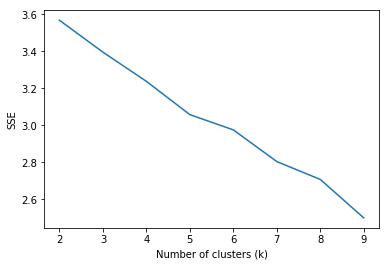

In [35]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(toronto_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

The elbow is not clear.


The following is the silhouette method.

In [36]:
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=1)
    preds = clusterer.fit_predict(toronto_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score (toronto_grouped_clustering, preds, metric='euclidean')
    print(n_clusters, round(score,4))

2 0.0711
3 0.0747
4 0.1171
5 0.0701
6 0.143
7 0.1033
8 0.0602
9 0.1133


The silhouette method shows that the optimal number of cluster is k=6 (the highest score). 

### k-means clustering
Run with k=6

In [37]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# Let's see how many stations belong to each cluster
print(Counter(kmeans.labels_))

Counter({1: 42, 3: 10, 0: 4, 2: 2, 5: 1, 4: 1})


Do the same procedure for the clustered neighborhood and create a dataframe.

In [38]:
# add clustering labels
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [39]:
#create new dataframe for the clustered stations (as the opposite to the stations in the dataframe above)
clustered_neighborhood = toronto_grouped

# Add coordinates to the dataset above
clustered_neighborhood = clustered_neighborhood.join(data.set_index('Neighborhood'), on='Neighborhood')
clustered_neighborhood.head()

,Cluster Labels,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Postal Code,Borough,Latitude,Longitude
0,2,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.

In [40]:
clustered_neighborhood_1=clustered_neighborhood

Visualize the result on the map and start with combining the result of the clustering with the neighborhood that have venues is equal or less than 5.

In [41]:
#Create a new dataframe and add a new "cluster" that is not equal to any of the existing clusters,
#just in order to be able to select by this cluster later in the project
quiet_neighborhood_1 = quiet_neighborhood
quiet_neighborhood_1['Cluster Labels'] = kclusters

#Add coordinates to the dataset above 
quiet_neighborhood_1 = quiet_neighborhood_1.join(data.set_index('Neighborhood'), on='Neighborhood')
# quiet_neighborhood_1.head()

In [42]:
# combine the clustered neighborhoods and the quiet neighborhood to create a map
toronto_merged = pd.concat([clustered_neighborhood, quiet_neighborhood_1], axis=0, ignore_index=True, sort=False)
toronto_merged_1 = toronto_merged[['Neighborhood','Cluster Labels','Latitude','Longitude']]
toronto_merged_1.head()

,Neighborhood,Cluster Labels,Latitude,Longitude
0,"Alderwood, Long Branch",2,43.602414,-79.543484
1,"Bathurst Manor, Wilson Heights, Downsview North",1,43.754328,-79.442259
2,"Bedford Park, Lawrence Manor East",1,43.733283,-79.419750
3,Berczy Park,1,43.644771,-79.373306
4,"Brockton, Parkdale Village, Exhibition Place",1,43.636847,-79.428191


In [43]:
toronto_merged_2=toronto_merged_1

Create the map where the real clusters

In [44]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_2['Latitude'], toronto_merged_2['Longitude'], toronto_merged_2['Neighborhood'], toronto_merged_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

Cluster 1 (cluster labels = 0) - purple circles


Cluster 2 (cluster labels = 1) - blue circles


Cluster 3 (cluster labels = 2) - cyan circles


Cluster 4 (cluster labels = 3) - olive circles


Cluster 5 (cluster labels = 4) - orange circles


Cluster 6 (quiet_neighborhood) (cluster labels = 5) - red circles

Calculate how many venues on the main venues category there are in each cluster to describe the clusters.

In [45]:
# Create new dataframe with only the cluster labels and neighborhood:
cluster_info=toronto_merged_1[['Cluster Labels','Neighborhood']]

# Merge this information with the dataframe that contains all of the venues and columns of the interest:
describe_clusters=main_cat
describe_clusters=describe_clusters.merge(cluster_info, how="left", on="Neighborhood")
# only keep neighborhoods are clustered
# describe_clusters_temp = describe_clusters[(describe_clusters['Cluster Labels'] >= 0) & (describe_clusters['Cluster Labels'] <= 5)]
# describe_clusters_temp.shape

describe_clusters_1=describe_clusters[['Neighborhood','Venue Category','Main Venues Category','Cluster Labels']]

# # Remove the data that we don't need (i.e. the neighborhood excluded from the clustering)
describe_clusters_1.drop(describe_clusters_1[describe_clusters_1['Cluster Labels'] == 6].index, inplace = True) 
describe_clusters_1.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Neighborhood,Venue Category,Main Venues Category,Cluster Labels
4,"Guildwood, Morningside, West Hill",Bank,Shop & Service,1
5,"Guildwood, Morningside, West Hill",Electronics Store,Shop & Service,1
6,"Guildwood, Morningside, West Hill",Mexican Restaurant,Food,1
7,"Guildwood, Morningside, West Hill",Rental Car Location,Travel & Transport,1
8,"Guildwood, Morningside, West Hill",Medical Center,Professional & Other Places,1


In [46]:
# cluster_info.shape
describe_clusters_1.shape
# describe_clusters_1.head()

(2125, 4)

**Describe clusters**

Calculate the numbers and percentage of venues in each cluster.

In [47]:
main_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Main Venues Category'])['Venue Category'].count().reset_index()
main_cat_clusters=main_cat_clusters.sort_values(by=['Venue Category'], ascending=False)
main_cat_cluster_0=main_cat_clusters[main_cat_clusters['Cluster Labels']==0]
main_cat_cluster_0['Percent'] = round(main_cat_cluster_0['Venue Category']/main_cat_cluster_0['Venue Category'].sum()*100,1)
main_cat_cluster_0=main_cat_cluster_0.sort_values('Main Venues Category', ascending=True)
main_cat_cluster_0

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Cluster Labels,Main Venues Category,Venue Category,Percent
0,0,Arts & Entertainment,7,3.5
1,0,College & University,1,0.5
2,0,Food,89,44.9
3,0,Nightlife Spot,6,3.0
4,0,Outdoors & Recreation,10,5.1
5,0,Professional & Other Places,2,1.0
6,0,Shop & Service,79,39.9
7,0,Travel & Transport,4,2.0


In [48]:
main_cat_cluster_1=main_cat_clusters[main_cat_clusters['Cluster Labels']==1]
main_cat_cluster_1['Percent'] = round(main_cat_cluster_1['Venue Category']/main_cat_cluster_1['Venue Category'].sum()*100,1)
main_cat_cluster_1=main_cat_cluster_1.sort_values('Main Venues Category', ascending=True)
main_cat_cluster_1

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cluster Labels,Main Venues Category,Venue Category,Percent
8,1,Arts & Entertainment,81,4.8
9,1,College & University,5,0.3
10,1,Food,987,57.9
11,1,Nightlife Spot,126,7.4
12,1,Outdoors & Recreation,122,7.2
13,1,Professional & Other Places,18,1.1
14,1,Shop & Service,302,17.7
15,1,Travel & Transport,64,3.8


In [49]:
main_cat_cluster_2=main_cat_clusters[main_cat_clusters['Cluster Labels']==2]
main_cat_cluster_2['Percent'] = round(main_cat_cluster_2['Venue Category']/main_cat_cluster_2['Venue Category'].sum()*100,1)
main_cat_cluster_2=main_cat_cluster_2.sort_values('Main Venues Category', ascending=True)
main_cat_cluster_2

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cluster Labels,Main Venues Category,Venue Category,Percent
16,2,Food,10,62.5
17,2,Nightlife Spot,1,6.2
18,2,Outdoors & Recreation,3,18.8
19,2,Shop & Service,1,6.2
20,2,Travel & Transport,1,6.2


In [50]:
main_cat_cluster_3=main_cat_clusters[main_cat_clusters['Cluster Labels']==3]
main_cat_cluster_3['Percent'] = round(main_cat_cluster_3['Venue Category']/main_cat_cluster_3['Venue Category'].sum()*100,1)
main_cat_cluster_3=main_cat_cluster_3.sort_values('Main Venues Category', ascending=True)
main_cat_cluster_3

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cluster Labels,Main Venues Category,Venue Category,Percent
21,3,Arts & Entertainment,1,0.5
22,3,Food,77,40.3
23,3,Nightlife Spot,3,1.6
24,3,Outdoors & Recreation,31,16.2
25,3,Professional & Other Places,1,0.5
26,3,Shop & Service,71,37.2
27,3,Travel & Transport,7,3.7


In [51]:
main_cat_cluster_4=main_cat_clusters[main_cat_clusters['Cluster Labels']==4]
main_cat_cluster_4['Percent'] = round(main_cat_cluster_4['Venue Category']/main_cat_cluster_4['Venue Category'].sum()*100,1)
main_cat_cluster_4=main_cat_cluster_4.sort_values('Main Venues Category', ascending=True)
main_cat_cluster_4

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cluster Labels,Main Venues Category,Venue Category,Percent
28,4,Food,2,28.6
29,4,Shop & Service,4,57.1
30,4,Travel & Transport,1,14.3


In [52]:
main_cat_cluster_5=main_cat_clusters[main_cat_clusters['Cluster Labels']==5]
main_cat_cluster_5['Percent'] = round(main_cat_cluster_5['Venue Category']/main_cat_cluster_5['Venue Category'].sum()*100,1)
main_cat_cluster_5=main_cat_cluster_5.sort_values('Main Venues Category', ascending=True)
main_cat_cluster_5

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cluster Labels,Main Venues Category,Venue Category,Percent
31,5,Food,3,37.5
32,5,Outdoors & Recreation,1,12.5
33,5,Travel & Transport,4,50.0


List top 5 common venues in each cluster.

In [53]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Venue Category'])['Main Venues Category'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['Main Venues Category'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==0].head(5)

,Cluster Labels,Venue Category,Main Venues Category
18,0,Clothing Store,24
19,0,Coffee Shop,16
31,0,Fast Food Restaurant,7
67,0,Restaurant,7
40,0,Japanese Restaurant,5


In [54]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Venue Category'])['Main Venues Category'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['Main Venues Category'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==1].head(5)

,Cluster Labels,Venue Category,Main Venues Category
142,1,Coffee Shop,151
131,1,Café,94
278,1,Restaurant,60
226,1,Italian Restaurant,42
227,1,Japanese Restaurant,36


In [55]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Venue Category'])['Main Venues Category'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['Main Venues Category'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==2].head(5)

,Cluster Labels,Venue Category,Main Venues Category
329,2,Pizza Place,4
324,2,Coffee Shop,2
332,2,Sandwich Place,2
327,2,Intersection,1
328,2,Middle Eastern Restaurant,1


In [56]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Venue Category'])['Main Venues Category'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['Main Venues Category'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==3].head(5)

,Cluster Labels,Venue Category,Main Venues Category
361,3,Grocery Store,17
377,3,Park,11
353,3,Fast Food Restaurant,10
380,3,Pizza Place,9
338,3,Bank,8


In [57]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Venue Category'])['Main Venues Category'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['Main Venues Category'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==4].head(5)

,Cluster Labels,Venue Category,Main Venues Category
400,4,Discount Store,2
401,4,Hobby Shop,1
397,4,Chinese Restaurant,1
398,4,Coffee Shop,1
399,4,Department Store,1


In [58]:
detailed_cat_clusters=describe_clusters_1.groupby(['Cluster Labels','Venue Category'])['Main Venues Category'].count().reset_index()
detailed_cat_clusters=detailed_cat_clusters.sort_values(by=['Main Venues Category'], ascending=False)
detailed_cat_clusters[detailed_cat_clusters['Cluster Labels']==5].head(5)

,Cluster Labels,Venue Category,Main Venues Category
403,5,Bus Line,2
402,5,Bakery,2
404,5,Bus Station,1
405,5,Ice Cream Shop,1
406,5,Intersection,1


## 4 Results

**Cluster 1**


This cluster is mainly located in the center of city. The most common venues categories are Food, Shop & Service, Outdoors & Recreation, and Arts & Entertainment. Within the Food category, the most common venues are Fast Food Restaurant and Japanese Restaurant.


**Cluster 2**


Most of restaurants in Toronto placed in these neighborhoods (987 food venues). This is a heaven for people loves food and hanging out with friends. This place is full of restaurants, shops, and universities. The most common venues categories are Food, Shop & Service, Arts & Entertainment, Nightlife Spot, and Outdoors & Recreation.


**Cluster 3** 


The most common venues categories are Food, Outdoors & Recreation, Shop & Service, Travel & Transport, and Nightlife Spot. This cluster has an average number of Food venues. The most common venues in Food category are Pizza Place and Coffee Shops. 


**Cluster 4**


This is the most diverse cluster. Here, we can find shops, restaurants, parks, banks, etc. This is the only cluster having ‘Park’ venue in the top 5 common venues. The most common venues categories are Food, Shop & Service, Outdoors & Recreation, and Travel & Transport.


**Cluster 5**


These neighborhoods are quite calm. There are few restaurants and coffee shops here. The most common venues categories are Shop & Service, Food, and Travel & Transport. The number of venues in this cluster is quite small.


**Cluster 6**


This is the quietest neighborhood. The number of venues reduce so much. There are few places for shopping or entertainments. The most common venues categories are Travel & Transport, Food, and Outdoors & Recreation. 



## 5 Discussion

Base on the results, cluster 6 is highly recommended neighborhoods for people who love quiescence. Young students can rent rooms in cluster 2 for their study as well as youth life. Cluster 1, 2, 3, and 4 are great places for people who wants to know more about Toronto cuisine.


We can enhance the results by importing more data related to schools and price for renting houses. If there are these two indices in Toronto data, people can have more reliable results to make their decisions.


## 6 Conclusion

This notebook aims to describe different neighborhoods in Toronto, project results can help people identify where is quiet, where is more crowded with lots of shopping centers, etc. From that, they can decide which places fits their lifestyle. We can cluster Toronto neighborhoods into 6 clusters, which are differentiate by the number of venues per neighborhood and the most common venues in each cluster. Cluster 1 to 4 also show a common in high percentage of Food categories. While cluster 5 and 6 indicate quiet neighborhoods. These results can be improved by adding more data about price of renting house and schoolings. 